# TS5: Estimación espectral: Ancho de banda de señales reales
### Autoras: Noelia Ferrari y Angelina Fantauzzo Fabio

**Consigna**: 
En el repositorio PDStestbench encontrará tres tipos de señales registradas:

Electrocardiograma (ECG). En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.
Pletismografía (PPG). El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.
Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

Se pide:

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.

Bonus:

💎 Proponga algún tipo de señal que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.


## Introducciones teóricas

### Densidad espectral 

En el análisis de señales, es muy importante conocer cómo se distribuye la energía de una señal a lo largo del dominio de la frecuencia. Esta información nos permite identificar componentes dominantes, ruido, interferencias y características propias de cada tipo de señal (por ejemplo, ECG, PPG o audio).
La herramienta principal para esto es la densidad espectral de potencia (PSD, Power Spectral Density). La PSD describe cómo se reparte la potencia de la señal en función de la frecuencia, y se define como:
$$P_x(f) = \lim_{T \to \infty} \frac{1}{T} \left| X_T(f) \right|^2$$
donde Xt(f) es la Transformada de Fourier de la señal truncada a un intervalo de duración T. 

Existen diferentes metodos para estimas este valor 

**Periodograma**
$$\hat{P}_{xx}(f) = \frac{1}{N} \left| \sum_{n=0}^{N-1} x[n] e^{-j 2 \pi f n / N} \right|^2$$


**Periodograma ventaneado**
$$\hat{P}_{xx}^{(w)}(f) = \frac{1}{\sum_{n=0}^{N-1} w^2[n]} \left| \sum_{n=0}^{N-1} x[n] w[n] e^{-j 2 \pi f n / N} \right|^2$$

Para mejorar el desparramiento espectral ventaneamos y luego transformamos.

**Método de Welch**
$$\hat{P}_{xx}^{\text{Welch}}(f) = \frac{1}{K} \sum_{k=1}^{K} \hat{P}_{xx,k}^{(w)}(f)$$

Divide la señal en segmentos solapados, aplica una ventana a cada segmento, calcula el periodograma de cada uno y luego promedia

**Blackman–Tukey**
$$\hat{P}_{xx}^{BT}(f) = \sum_{m=-M}^{M} w[m] r_{xx}[m] e^{-j 2 \pi f m / N}$$

Se basa en mejorar la secuencia de autocorrelación rxx[m] de la señal y una ventana de suavizado w[m]


Cada uno de estos metodos buscan mejorar la varianza y la resolucion espectral. Al analizarlos se llega a la conclusion de que existe una relacion de compromiso entre estos dos, si se mejora uno empeora el otro.

### Ancho de banda

El ancho de banda de una señal es el rango de frecuencias donde la señal concentra la mayor parte de su energía.

Este se puede analizar de diversas formas:

1) Definir el ancho de banda es mediante un umbral relativo respecto a la potencia máxima, por ejemplo a −3 dB.
   $$BW = f_{\max} - f_{\min}, \quad \text{donde } P(f) \ge \frac{P_{\max}}{2}$$
   donde fmin y fmax son las frecuencias donde la PSD cae por debajo de la mitad de su valor máximo.

2) calcular el ancho de banda equivalente mediante la integral de la PSD:
    $$BW_\text{eq} = \frac{\int_0^{\infty} P(f) df}{P_\max}$$


Graficamente, el ancho de banda se puede visualizar como la región en frecuencia donde la señal tiene energía significativa, mientras que fuera de esa región la potencia es muy baja y se considera ruido o componentes irrelevantes.

# Desarollo del codigo 

In [5]:
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io.wavfile import write

In [6]:
def blackman_tukey(x, M=None):
    """Estimador de PSD por el método de Blackman–Tukey."""
    N = len(x)
    if M is None:
        M = N // 5
    r_len = 2 * M - 1
    r = np.correlate(x[:r_len], x[:r_len], mode='same') / r_len
    Px = np.abs(np.fft.fft(r * sig.windows.blackman(r_len), n=N))
    return Px

## Punto 1

### Primer señal: ECG con ruido

In [7]:
mat_struct = sio.loadmat('ECG_TP4.mat')
ecg = mat_struct['ecg_lead'].squeeze()   # <-- convierte (N,1) en (N,)
ecg = ecg - np.mean(ecg)
N = len(ecg)
fs_ecg = 1000 # Hz

In [8]:
# Periodograma de ECG
f_per, P_per = sig.periodogram(ecg, fs=fs_ecg)

#welch 
f_welch, P_welch = sig.welch(ecg, fs=fs_ecg)

#periodograma ventaneado con hann
window = sig.windows.hann(N)
f_win, P_win = sig.periodogram(ecg, fs=fs_ecg, window=window, scaling='density')

#blackman tuckey 
P_bt = blackman_tukey(ecg)
f_bt = np.linspace(-fs_ecg/2, fs_ecg/2, len(P_bt))

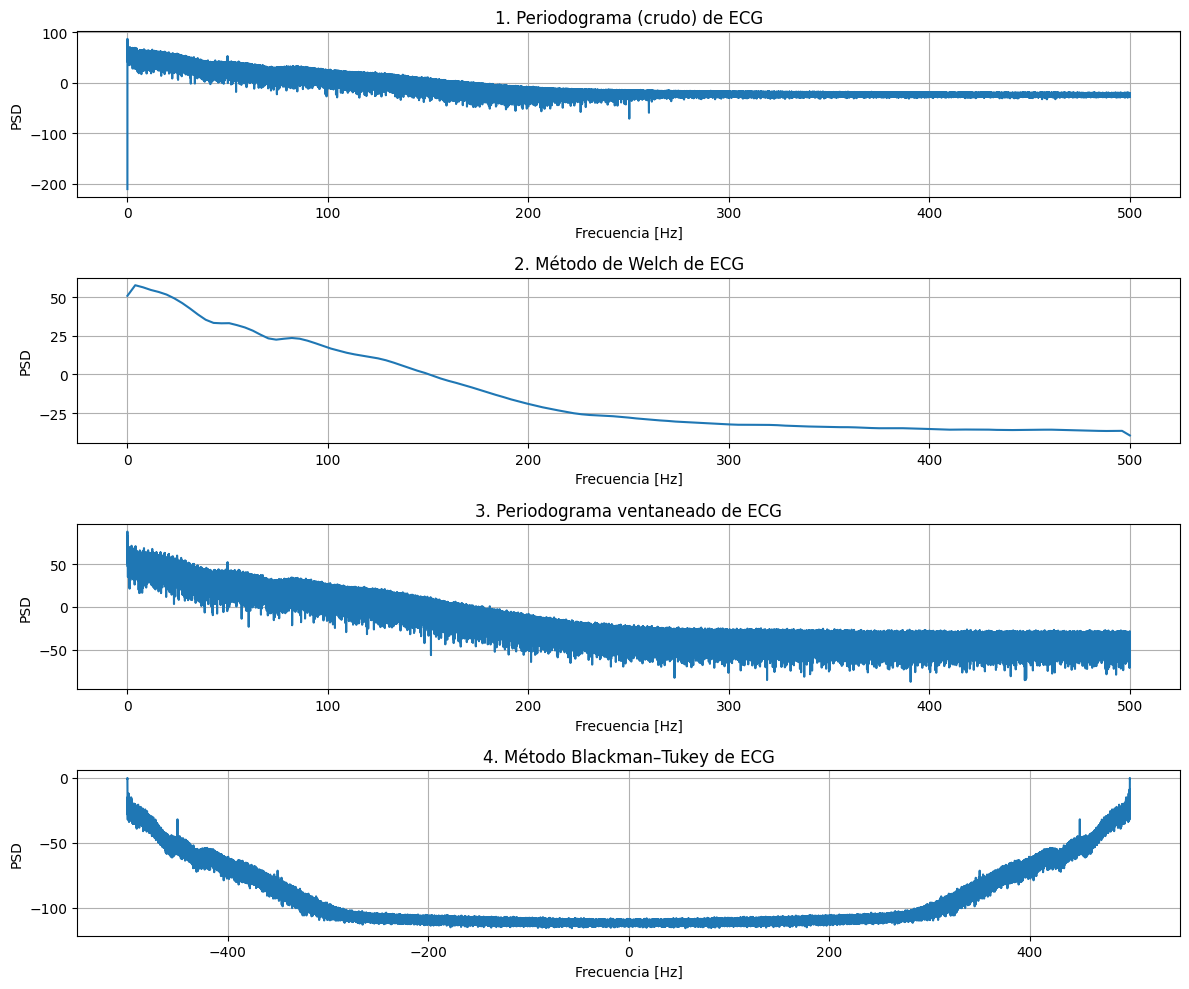

In [9]:
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(f_per, 10*np.log10(P_per))
plt.title('1. Periodograma (crudo) de ECG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(f_welch, 10*np.log10(P_welch))
plt.title('2. Método de Welch de ECG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(f_win, 10*np.log10(P_win))
plt.title('3. Periodograma ventaneado de ECG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(f_bt, 10*np.log10(P_bt / np.max(P_bt)))
plt.title('4. Método Blackman–Tukey de ECG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.tight_layout()
plt.show()

### Segunda señal: PPG con ruido

In [10]:
fs_ppg = 400 # Hz
ppg = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1)  # Omitir la cabecera si existe
N_ppg = len(ppg)

In [11]:
# Periodograma de ECG
f2_per, P2_per = sig.periodogram(ppg, fs=fs_ppg)

#welch 
f2_welch, P2_welch = sig.welch(ppg, fs=fs_ppg)

#periodograma ventaneada
window = sig.windows.hann(N_ppg)
f2_win, P2_win = sig.periodogram(ppg, fs=fs_ppg,  window=window, scaling='density')

#blackman tuckey
P_bt_2 = blackman_tukey(ppg)
f_bt_2 = np.linspace(-fs_ppg/2, fs_ppg/2, len(P_bt_2))

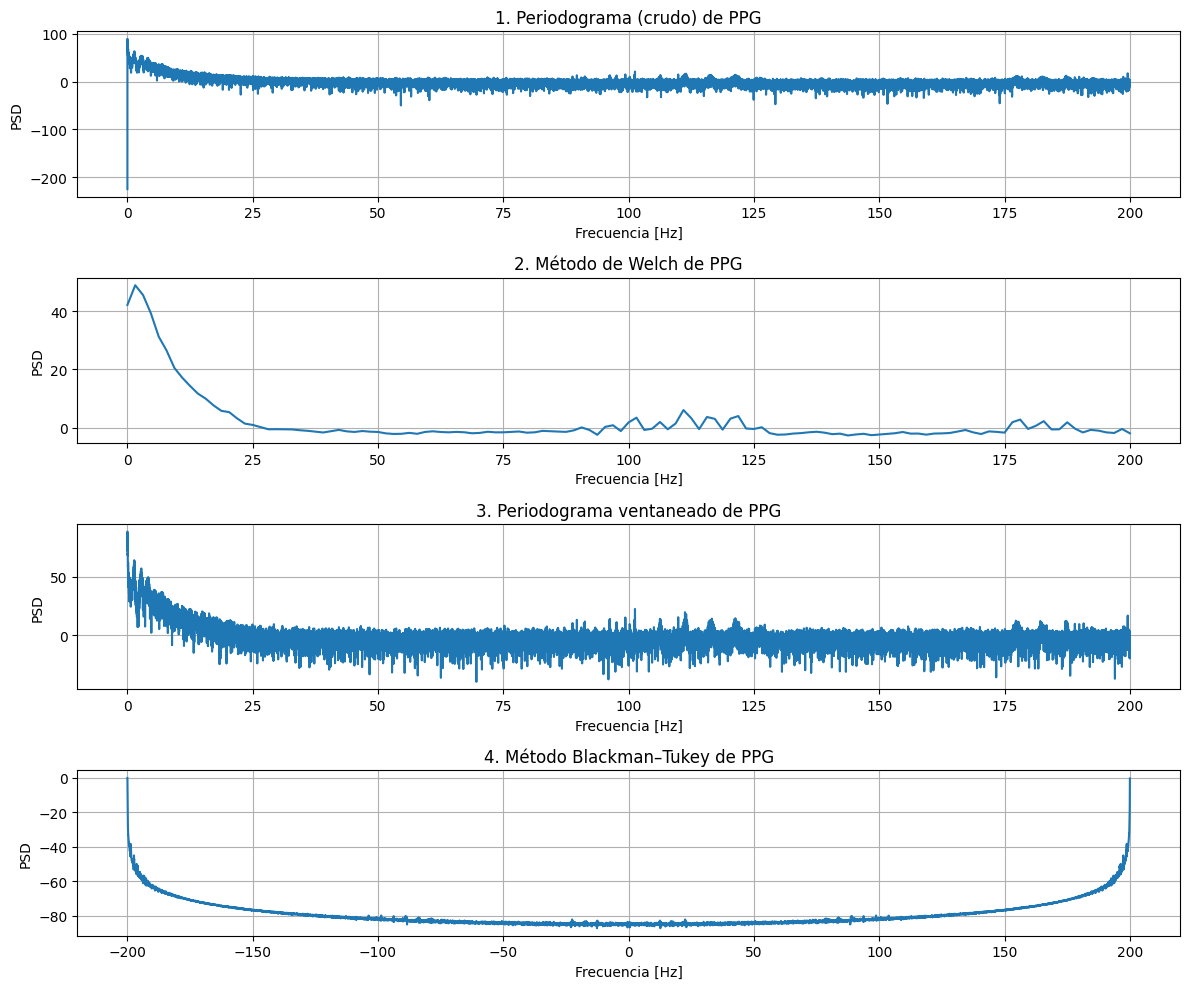

In [12]:
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(f2_per, 10*np.log10(P2_per))
plt.title('1. Periodograma (crudo) de PPG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(f2_welch, 10*np.log10(P2_welch))
plt.title('2. Método de Welch de PPG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(f2_win, 10*np.log10(P2_win))
plt.title('3. Periodograma ventaneado de PPG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(f_bt_2, 10*np.log10(P_bt_2 / np.max(P_bt_2)))
plt.title('4. Método Blackman–Tukey de PPG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.tight_layout()
plt.show()

### Tercer señal: audio "la cucaracha"

In [13]:
fs_audio, audio = sio.wavfile.read('la cucaracha.wav')
audio = audio.astype(float)
audio = audio - np.mean(audio)
N_audio = len(audio)

In [14]:
#periodograma crudo
f_raw, P_raw = sig.periodogram(audio, fs=fs_audio, scaling='density')

#periodograma ventaneado (Hann)
window = sig.windows.hann(N_audio)
f_win, P_win = sig.periodogram(audio, fs=fs_audio, window=window, scaling='density')

#welch (promediado)
f_welch, P_welch = sig.welch(audio, fs=fs_audio, window='hann', nperseg=2048, noverlap=1024)

#blackman–Tukey
P_bt = blackman_tukey(audio)
f_bt = np.linspace(-fs_audio / 2, fs_audio / 2, len(P_bt))

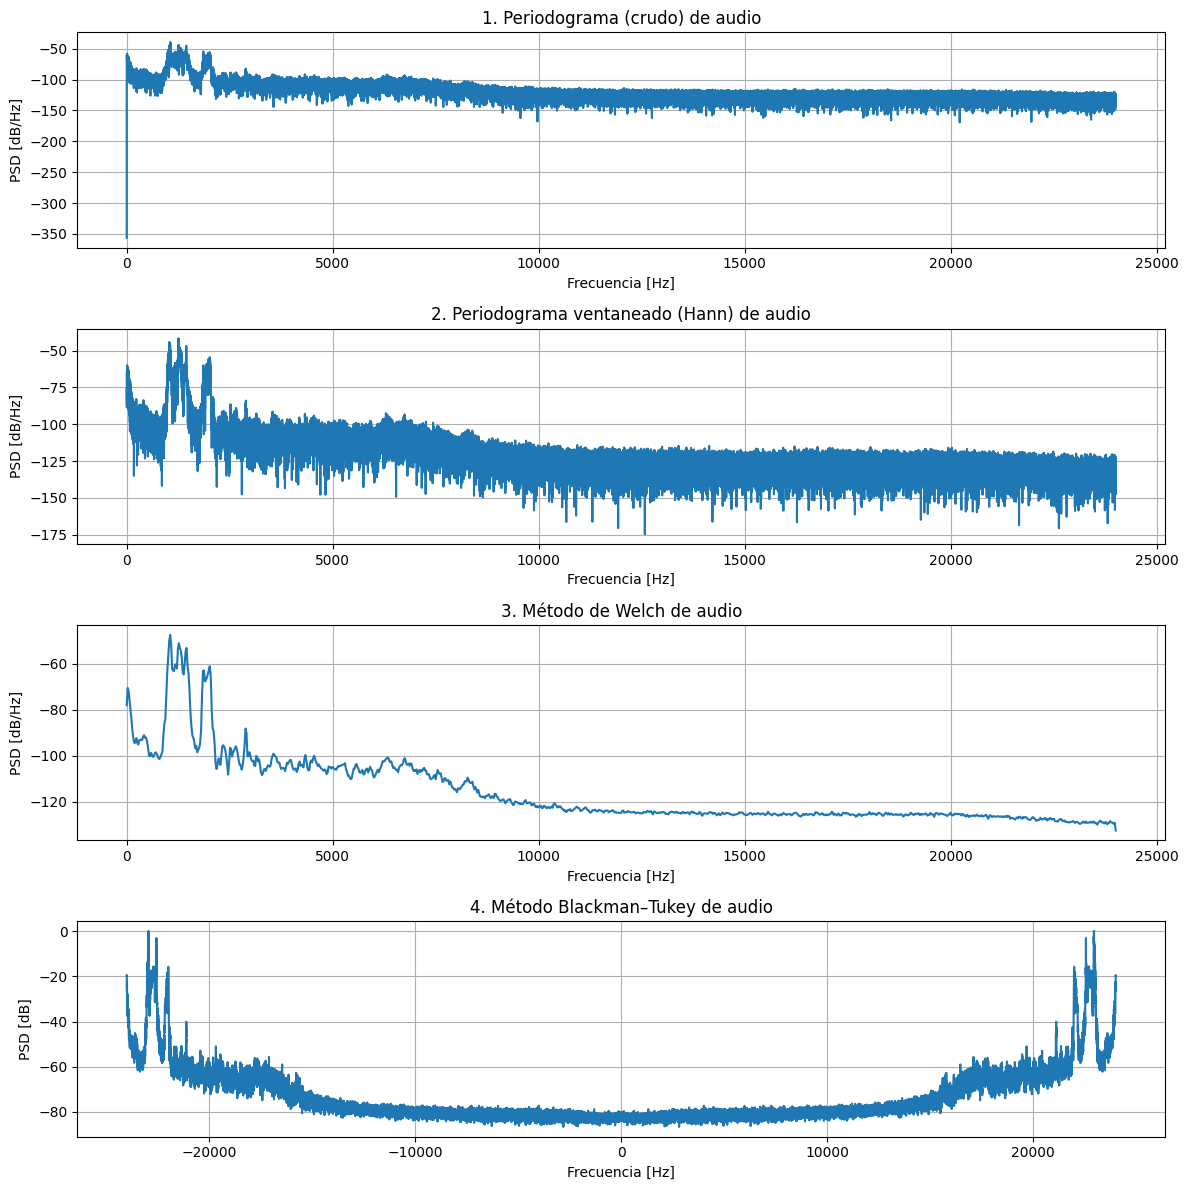

In [15]:
plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.plot(f_raw, 10 * np.log10(P_raw))
plt.title('1. Periodograma (crudo) de audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(f_win, 10 * np.log10(P_win))
plt.title('2. Periodograma ventaneado (Hann) de audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(f_welch, 10 * np.log10(P_welch))
plt.title('3. Método de Welch de audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(f_bt, 10 * np.log10(P_bt / np.max(P_bt)))
plt.title('4. Método Blackman–Tukey de audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.grid(True)

plt.tight_layout()
plt.show()

### Analisis de los resultados del punto 1

Podemos observar

## Punto 2